# Part 1 - MNIST

<table align="left"><td>
<a target="_blank" href="https://colab.research.google.com/github/thomasjpfan/skorch_talk/blob/master/part_1_mnist.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>  
</td><td>
<a target="_blank" href="https://github.com/thomasjpfan/skorch_talk/blob/master/part_1_mnist.ipynb"><img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a></td></table>

**Note**: If you are running this in [a colab notebook](https://colab.research.google.com/github/thomasjpfan/skorch_talk/blob/master/part_1_mnist.ipynb), we recommend you enable a free GPU by going:

> **Runtime**   →   **Change runtime type**   →   **Hardware Accelerator: GPU**

If you are running in colab, you should install the dependencies and download the dataset by running the following cell:

In [2]:
! [ ! -z "$COLAB_GPU" ] && pip install skorch

## Explore data

In [0]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from urllib import request

In [4]:
def download_mnist(dataset_dir=Path('data')):
    dataset_dir.mkdir(exist_ok=True)
    mnist_data = dataset_dir / 'mnist.npz'
    url = 'https://github.com/thomasjpfan/skorch_talk/blob/master/data/mnist.npz?raw=true'
    if not mnist_data.exists():
        print("Starting to download data...")
        data = request.urlopen(url, timeout=15).read()
        with open(mnist_data, 'wb') as f:
            f.write(data)
    print("Data has been downloaded to {}.".format(dataset_dir))
    
download_mnist()

Starting to download data...
Data has been downloaded to data.


In [0]:
mnist = np.load('data/mnist.npz', allow_pickle=True)

In [6]:
X = mnist['data'].astype('float32')
y = mnist['target'].astype('int64')

print(X.shape, y.shape)

(70000, 784) (70000,)


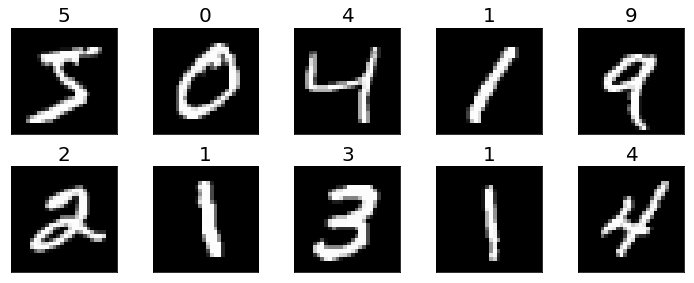

In [7]:
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
fig.patch.set_alpha(0)
Path('images').mkdir(exist_ok=True)

for idx, ax in enumerate(axes.flatten()):
    ax.imshow(X[idx].reshape(28, 28), cmap='gray')
    ax.set_title(y[idx], fontsize=20)
    ax.set_xticks([])
    ax.set_yticks([])
fig.tight_layout()
fig.savefig('images/mnist_example.png')

## Simple Neutral Model

In [0]:
import torch.nn as nn

class SimpleFeedforward(nn.Module):
    def __init__(self, dropout=0.5):
        super().__init__()
        self.module = nn.Sequential(
            nn.Linear(784, 98),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(98, 10)
        )
    def forward(self, X):
        return self.module(X)

In [0]:
from sklearn.model_selection import train_test_split

X_scaled = X / X.max()

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.25, random_state=42)

In [0]:
from skorch import NeuralNet

net = NeuralNet(
    SimpleFeedforward,
    criterion=nn.CrossEntropyLoss,
    max_epochs=10,
    lr=0.3,
    device='cuda', # comment out to run on cpu
)

In [11]:
_ = net.fit(X_train, y_train)

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.5725        0.3651  0.9327
      2        0.3142        0.2735  0.8396
      3        0.2653        0.1859  0.8433
      4        0.2362        0.1615  0.8500
      5        0.2164        0.1434  0.8448
      6        0.2020        0.1577  0.8568
      7        0.1958        0.1304  0.8429
      8        0.1850        0.1321  0.8449
      9        0.1755        0.1226  0.8510
     10        0.1718        0.1304  0.8497


In [12]:
net.set_params(max_epochs=5)
_ = net.partial_fit(X_train, y_train)

     11        0.1648        0.1129  0.8646
     12        0.1597        0.1100  0.8572
     13        0.1521        0.1139  0.8666
     14        0.1495        0.1120  0.8500
     15        0.1451        0.1105  0.8549


## History

In [13]:
len(net.history)

15

In [14]:
net.history[-1, 'valid_loss']

0.11050002356937953

In [15]:
net.history[-2:, 'train_loss']

[0.14953009933517092, 0.14514406461942764]

## Callbacks

### EpochScoring

In [16]:
y_pred = net.predict(X_test)
print(y_pred.shape)
print(y_pred[0, :])

(17500, 10)
[-8.3347     0.7850033  6.4455976  6.909385  -9.811217   5.438596
 -9.500775  -2.8927622 15.760244  -4.2489367]


In [17]:
def accuracy_argmax(y_true, y_pred):
    return np.mean(y_true == np.argmax(y_pred, -1))

print('test accuracy:', accuracy_argmax(y_test, y_pred))

test accuracy: 0.9653142857142857


In [0]:
from sklearn.metrics import make_scorer
from skorch.callbacks import EpochScoring

accuracy_argmax_scorer = make_scorer(accuracy_argmax)

epoch_acc = EpochScoring(
    accuracy_argmax_scorer,
    name='valid_acc',
    lower_is_better=False)

In [0]:
net = NeuralNet(
    SimpleFeedforward,
    criterion=nn.CrossEntropyLoss,
    max_epochs=10,
    lr=0.3,
    device='cuda',
    callbacks=[epoch_acc]
)

In [20]:
_ = net.fit(X_train, y_train)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.5739       0.9031        0.3159  0.8901
      2        0.3232       0.9273        0.2321  0.8563
      3        0.2691       0.9260        0.2317  0.8619
      4        0.2414       0.9484        0.1716  0.8594
      5        0.2192       0.9562        0.1459  0.8606
      6        0.2056       0.9534        0.1505  0.8599
      7        0.1948       0.9588        0.1361  0.8599
      8        0.1862       0.9570        0.1389  0.8536
      9        0.1770       0.9615        0.1261  0.8498
     10        0.1761       0.9630        0.1229  0.8587


## Integration with sklearn

In [0]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

In [0]:
pipe = Pipeline([
    ('min_max', MinMaxScaler()),
    ('net', net)
])

In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)
_ = pipe.fit(X_train, y_train)

Re-initializing module.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.5760       0.9024        0.3209  0.8915
      2        0.3174       0.9290        0.2390  0.8827
      3        0.2667       0.9440        0.1848  0.8939
      4        0.2375       0.9451        0.1787  0.8833
      5        0.2195       0.9532        0.1536  0.8874
      6        0.2052       0.9508        0.1560  0.8902
      7        0.1967       0.9550        0.1448  0.8973
      8        0.1833       0.9626        0.1245  0.8824
      9        0.1763       0.9610        0.1295  0.8813
     10        0.1698       0.9641        0.1190  0.8838


In [0]:
from sklearn.model_selection import GridSearchCV

pipe.set_params(net__verbose=0)
param_grid = {
    'net__module__dropout': [0.2, 0.5, 0.8]
}

gs = GridSearchCV(pipe, param_grid, 
                  scoring=accuracy_argmax_scorer, 
                  cv=3, verbose=3)

In [25]:
_ = gs.fit(X, y)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] net__module__dropout=0.2 ........................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............ net__module__dropout=0.2, score=0.966, total=   9.9s
[CV] net__module__dropout=0.2 ........................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.9s remaining:    0.0s


[CV] ............ net__module__dropout=0.2, score=0.963, total=   9.6s
[CV] net__module__dropout=0.2 ........................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   19.6s remaining:    0.0s


[CV] ............ net__module__dropout=0.2, score=0.968, total=   9.6s
[CV] net__module__dropout=0.5 ........................................
[CV] ............ net__module__dropout=0.5, score=0.958, total=   9.6s
[CV] net__module__dropout=0.5 ........................................
[CV] ............ net__module__dropout=0.5, score=0.958, total=   9.7s
[CV] net__module__dropout=0.5 ........................................
[CV] ............ net__module__dropout=0.5, score=0.964, total=   9.7s
[CV] net__module__dropout=0.8 ........................................
[CV] ............ net__module__dropout=0.8, score=0.937, total=   9.5s
[CV] net__module__dropout=0.8 ........................................
[CV] ............ net__module__dropout=0.8, score=0.932, total=   9.5s
[CV] net__module__dropout=0.8 ........................................
[CV] ............ net__module__dropout=0.8, score=0.944, total=   9.5s


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.4min finished


In [26]:
print("best score:", gs.best_score_)
print("best_params", gs.best_params_)

best score: 0.9658857142857142
best_params {'net__module__dropout': 0.2}


## Conform to scikit-learn Classifer

In [0]:
from sklearn.base import ClassifierMixin
from sklearn.utils.extmath import softmax
from skorch import NeuralNet

class MyNNClassifer(ClassifierMixin, NeuralNet):
    def fit(self, X, y, **fit_params):
        super().fit(X, y, **fit_params)
        self.classes_ = np.unique(y)
  
    def predict_proba(self, X):
        y_pred = super().predict_proba(X)
        return softmax(y_pred)
      
    def predict(self, X):
        y_pred = super().predict(X)
        return np.argmax(y_pred, axis=1)

In [0]:
from skorch.callbacks import EpochScoring
epoch_acc = EpochScoring(
    'accuracy',
    name='valid_acc',
    lower_is_better=False)

net = MyNNClassifer(
    SimpleFeedforward,
    criterion=nn.CrossEntropyLoss,
    max_epochs=10,
    lr=0.3,
    device='cuda', # comment out to run on cpu
    callbacks=[epoch_acc]
)

In [52]:
_ = net.fit(X_train, y_train)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.5763       0.8983        0.3319  1.1257
      2        0.3164       0.9327        0.2233  1.0862
      3        0.2666       0.9319        0.2189  1.0448
      4        0.2388       0.9508        0.1626  1.0473
      5        0.2149       0.9431        0.1800  1.0277
      6        0.2037       0.9561        0.1465  1.0530
      7        0.1917       0.9591        0.1343  1.0409
      8        0.1815       0.9613        0.1277  1.0335
      9        0.1763       0.9631        0.1221  1.0309
     10        0.1709       0.9621        0.1273  1.0402


In [39]:
net.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [0]:
y_test_pred = net.predict(X_test)

In [41]:
y_test_pred[0: 2]

array([8, 4])

In [0]:
y_test_pred_proba = net.predict_proba(X_test)

In [43]:
y_test_pred_proba[0:2, :]

array([[2.71880793e-07, 3.25494000e-07, 1.12523943e-04, 3.65644810e-03,
        1.11876930e-09, 2.35797212e-04, 1.20907435e-08, 7.18731812e-08,
        9.95992780e-01, 1.83940176e-06],
       [9.76298122e-12, 2.07509760e-08, 8.03121181e-11, 5.19260990e-09,
        9.99871612e-01, 2.94302449e-09, 2.53785742e-10, 1.11806148e-04,
        6.08241280e-09, 1.65573420e-05]], dtype=float32)